In [105]:
using Revise
using Distributions
using LoopVectorization
using BeamPropagation, StaticArrays, DelimitedFiles, BenchmarkTools
using Plots, StructArrays, StatsBase
using PhysicalConstants.CODATA2018

┌ Info: Precompiling BeamPropagation [3b7771b3-0fff-45f6-8d8e-6a934b658944]
└ @ Base loading.jl:1317


# Define constants

In [106]:
# Define constants
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Γ = @with_unit 2π * 8.3 "MHz"
const Iₛ = @with_unit 5.0 "mW/cm^2"
const w = @with_unit 2.5 "cm"
const P = @with_unit 250.0 "mW"
const μ = @with_unit 1 "μB"
;

# Magnetic field setup

In [107]:
# Prepare magnetic field data
Barr = readdlm("./B_realistic_fieldAndGrad.txt")
xin = Barr[:,1]; yin = Barr[:,2]; zin = Barr[:,3]
Bnormin = Barr[:,4]
dBdxin = Barr[:,5]; dBdyin = Barr[:,6]; dBdzin = Barr[:,7]

# make look up tables
dFlut = Array{SVector{2, Float64}}(undef, 401, 1601)
Bnormlut = zeros(Float64, (401,1601))

for (i, (x,z)) in enumerate(zip(xin, zin))
    ix = round(Int, x/(0.018)*400+1)
    iz = round(Int, (z+0.264)/(2*0.264)*1600+1)
    
    dFlut[ix,iz] = SVector(dBdxin[i], dBdzin[i]) * (μ/m)
    Bnormlut[ix,iz] = Bnormin[i]
end

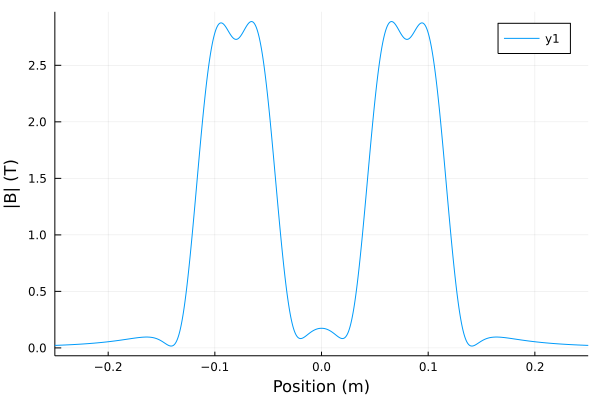

In [108]:
plot(unique(zin),Bnormlut[1,:], xaxis="Position (m)", yaxis="|B| (T)")
xlims!(-0.25,0.25)

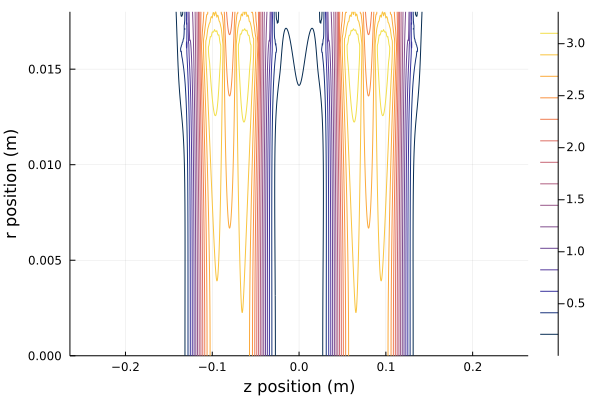

In [109]:
contour(unique(zin),unique(xin),Bnormlut, c=:thermal)
xlabel!("z position (m)")
ylabel!("r position (m)")

In [110]:
rectangle(w, h, x, y) = Shape(x-(w/2) .+ [0,w,w,0], y .+ [0,0,h,h])

function plotmagnet()
    buck_outer = [0.02,0.0105,-0.132,0.016]
    buck_inner = [0.012,0.0105,-0.028,0.016]
    sol_outer = [0.026, 0.023, 0.1, 0.016]
    sol_inner = [0.026, 0.023, 0.06, 0.016]
    plot(rectangle(buck_outer[1],buck_outer[2],buck_outer[3],buck_outer[4]),color="grey")
    plot!(rectangle(buck_outer[1],-buck_outer[2],buck_outer[3],-buck_outer[4]),color="grey")
    plot!(rectangle(buck_outer[1],buck_outer[2],-buck_outer[3],buck_outer[4]),color="grey")
    plot!(rectangle(buck_outer[1],-buck_outer[2],-buck_outer[3],-buck_outer[4]),color="grey")
    plot!(rectangle(buck_inner[1],buck_inner[2],buck_inner[3],buck_inner[4]),color="grey")
    plot!(rectangle(buck_inner[1],-buck_inner[2],buck_inner[3],-buck_inner[4]),color="grey")
    plot!(rectangle(buck_inner[1],buck_inner[2],-buck_inner[3],buck_inner[4]),color="grey")
    plot!(rectangle(buck_inner[1],-buck_inner[2],-buck_inner[3],-buck_inner[4]),color="grey")
    plot!(rectangle(sol_outer[1],sol_outer[2],sol_outer[3],sol_outer[4]),color="grey")
    plot!(rectangle(sol_outer[1],-sol_outer[2],sol_outer[3],-sol_outer[4]),color="grey")
    plot!(rectangle(sol_outer[1],sol_outer[2],-sol_outer[3],sol_outer[4]),color="grey")
    plot!(rectangle(sol_outer[1],-sol_outer[2],-sol_outer[3],-sol_outer[4]),color="grey")
    plot!(rectangle(sol_inner[1],sol_inner[2],sol_inner[3],sol_inner[4]),color="grey")
    plot!(rectangle(sol_inner[1],-sol_inner[2],sol_inner[3],-sol_inner[4]),color="grey")
    plot!(rectangle(sol_inner[1],sol_inner[2],-sol_inner[3],sol_inner[4]),color="grey")
    plot!(rectangle(sol_inner[1],-sol_inner[2],-sol_inner[3],-sol_inner[4]),color="grey")
end

plotmagnet (generic function with 1 method)

# Optical pumping parameters

In [111]:
nmol = 100

num_gs = 12; num_es = 4;

TItab = [0 0.0003 0 0.0833 0 0.1656 0 0.0833 0 0.0008 0 0;
         0.0835 0 0.0830 0 0.0003 0 0.0007 0 0 0 0.1657 0;
         0 0.1662 0 0.0007 0 0.0004 0 0 0 0.0827 0 0.0833;
         0 0 0.0007 0 0.1662 0 0.0829 0 0.0831 0 0.0004 0]

BRtab = [0 0.001 0 0.167 0 0.331 0 0.167 0.333 0.002 0 0;
         0.167 0 0.166 0 0.001 0.002 0.001 0 0 0.332 0.331 0;
         0.333 0.332 0 0.001 0 0.001 0 0 0 0.165 0 0.167;
         0 0.001 0.001 0.332 0.332 0 0.166 0 0.166 0 0.001 0]

const g_to_e_TotalProb = sum(TItab, dims=1)
const end_gs = collect(1:nmol)
const μ_signs = SVector(-1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1)
const wvs = Array{Weights{Float64,Float64,Array{Float64,1}}}(undef, num_gs)

TIBRtab = zeros(Float64, num_gs, num_gs);
for g in 1:num_gs, g′ in 1:num_gs
    for e in 1:num_es
        TIBRtab[g, g′] += TItab[e, g] * BRtab[e, g′] # Probability of gstate -> estate -> gstate′
    end
end

for g in 1:num_gs
    wvs[g] = Weights(TIBRtab[g, :])
end

In [112]:
@inline Rsc(s, δ) =  (Γ / 2) * (s / (1 + s + 4(δ/Γ)^2))
@inline detuning(Δ, UB, vz) = 2π * (Δ + UB / h + 0*vz / λ) # multiply Doppler term by 0 since we're going transverse

@inline function Prob(g, s, δ, dt0)::Tuple{Float64, Float64}
    
    # Calculate the probability density (over time) of a photon scatter event
    p_density = Rsc(s, δ) * g_to_e_TotalProb[g]
    
    # Update the time-step of the particle such that the total probability is at most 0.1, i.e., p_density * dt <= 0.1
    if (p_density * dt0 > 0.1) && !iszero(p_density)
        dt = 0.1 / p_density
    else
        dt = dt0
    end
    
    return (dt, p_density * dt)
end

@inline function scatterphoton(ix, iz, Bnormlut, g, Δ, v, dt0)::Tuple{Float64, Bool, Int64}
        
    P0 = 2P / (Iₛ * π * w^2)
    β = P0 #P0 * exp(-(x^2 + y^2) / (2w^2))
    
    if (1 <= ix <= size(Bnormlut, 1)) && (1 <= iz <= size(Bnormlut, 2))
    
        UB = μ * μ_signs[g] * Bnormlut[ix, iz]
        δ = detuning(Δ, UB, v)

        (dt, prob) = Prob(g, β, δ, dt0)

        if rand() > prob
            scat = false
            g′ = g
        else
            scat = true
            g′ = sample(end_gs, wvs[g])
        end
    else
        dt = dt0
        scat = false
        g′ = g
    end
    return (dt, scat, g′)
end
;

# Propagation functions

In [113]:
const detect_rad  = @with_unit 1.6 "cm"
const detect_zloc = @with_unit 70 + 26 "cm"
const detect_zlen = @with_unit 1.3 "cm"
const dead_rad = @with_unit 1.25 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [183]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline function discard(r,v)
    discarded = false
    ρ = sqrt(r[1]^2+r[2]^2)
    if (r[3] + 0.15) < 0.01 && ρ > 0.005
        discarded = true
#     elseif ρ > dead_rad
#         discarded = true
    elseif r[3] > dead_len
        discarded = true
    elseif v[3] < 0
        discarded = true
    end
    return discarded
end

@inline is_detectable(r) = (sqrt(r[1]^2 + r[2]^2) < detect_rad) && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        dt = particles.dt[i]
        r = particles.r[i]
        vz = particles.v[i][3]
        
        push!(s.rs[idx], r)
        push!(s.vzs[idx], vz)
        push!(s.dts[idx], dt)
    end
    return nothing
end

@inline function update(particles, p, s, dt)
    
    for i in 1:size(particles, 1)
        
        idx   = particles.idx[i]
        state = p.states[idx]
        
        r = particles.r[i]
        x, y, z = r
        v = particles.v[i]
        ρ = sqrt(x^2 + y^2)
        
        if z > -0.264 && z < 0.264
            ix = round(Int, ρ/(0.018)*400+1)
            iz = round(Int, (z+0.264)/(2*0.264)*1600+1)

            pump_region_HF_1 = 0.065
            pump_region_HF_2 = 0.095
            pump_region_LF = 0.02
            
            if (-pump_region_HF_1 > z > -pump_region_HF_2) && p.lasers_on[1]
                
                Δ = p.Δs[1]
                dt′, scat, state′ = scatterphoton(ix, iz, p.Bnormlut, state, Δ, v[3], p.dt0)
                particles.dt[i] = dt′
                particles.use_adaptive[i] = false
                s.photons[idx] += scat
                
            elseif (pump_region_LF > abs(z)) && (p.lasers_on[2])
                
                Δ = p.Δs[2]
                dt′, scat, state′ = scatterphoton(ix, iz, p.Bnormlut, state, Δ, v[3], p.dt0)
                particles.dt[i] = dt′
                particles.use_adaptive[i] = false
                s.photons[idx] += scat
                
            elseif (pump_region_HF_1 < z < pump_region_HF_2) && p.lasers_on[3]
                
                Δ = p.Δs[1]
                dt′, scat, state′ = scatterphoton(ix, iz, p.Bnormlut, state, Δ, v[3], p.dt0)
                particles.dt[i] = dt′
                particles.use_adaptive[i] = false
                s.photons[idx] += scat
                
            elseif (0.13 < z < 0.17) && p.lasers_on[4]
                
                Δ = p.Δs[2]
                dt′, scat, state′ = scatterphoton(ix, iz, p.Bnormlut, state, Δ, v[3], p.dt0)
                particles.dt[i] = dt′
                particles.use_adaptive[i] = false
                s.photons[idx] += scat
                
            else
                state′ = state
                
                # Turn adaptive time-stepping back on outside the magnets
                particles.use_adaptive[i] = true
            end
            p.states[idx] = state′
        end
        s.detectable[idx] |= is_detectable(r)
    end
    
    return nothing
end

@inline function f(idx, r, v, p)
    x, y, z = r
    ρ = sqrt(x^2 + y^2)

    state = p.states[idx]
    
    if z > -0.264 && z < 0.264
        ix = round(Int, ρ/(0.018)*400+1)
        iz = round(Int, (z+0.264)/(2*0.264)*1600+1)
        
        if (1 <= ix <= size(p.dFlut, 1)) && (1 <= iz <= size(p.dFlut, 2))
        # compute force and rotate to Cartesian
            a′ = - p.Bscale * μ_signs[state] * SVector(
                p.dFlut[ix, iz][1] * x / ρ,
                p.dFlut[ix, iz][1] * y / ρ,
                p.dFlut[ix, iz][2]
            )
        else
            a′ = SVector(0, 0, 0)
        end
    else # if we're not anywhere near the magnets...
        a′ = SVector(0, 0, 0)
    end
    
    return a′
end
;

# Run trajectories

In [184]:
# CBGB properites
vz_μ = @with_unit 45 "m/s"
vz_σ = @with_unit 30/2.35 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 5 "m/s"
exit_radius = @with_unit 5 "mm"
z_start = @with_unit (-26.4-40) "cm"

const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(z_start, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0),
    Normal(0, 0),
    Normal(0, 0)
)
;

In [213]:
# Parameters required by beam propagation simulation
n = 500000
save_every = 40
delete_every = 40
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(3.5e5)
alg = "rkf12"
use_adaptive = true
;

In [214]:
function test(x, b)
    
    n = length(x)
    chunk_size = round(Int64, n / Threads.nthreads())
    
    Threads.@threads for i in 1:size(x, 1)
        
#         start_idx   = (i-1)*chunk_size+1
#         end_idx     = min(i*chunk_size, n)
#         chunk_idxs  = start_idx:end_idx
#         actual_chunk_size = length(chunk_idxs)
        
        b[i] = exp(x[i])
        
    end
end

test (generic function with 1 method)

In [293]:
Δs = [-38e9, 2.0e9]
lasers_on = [true, true, true, false]
dt0 = 1e-5
states = rand(1:12, n)
Bscale = 1.0
p = @params (Δs, Bnormlut, dFlut, lasers_on, dt0, states, Bscale)

rs = [Array{SVector{3, Float64}}(undef, 0) for _ in 1:n]
vzs = [Array{Float64}(undef, 0) for _ in 1:n]
dts = [Array{Float64}(undef, 0) for _ in 1:n]
detectable = zeros(Bool, n)
photons = zeros(Int64, n)
s = @params (rs, vzs, dts, detectable, photons)

using StructArrays
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)

  6.122632 seconds (2.61 M allocations: 576.118 MiB, 16.45% gc time, 0.38% compilation time)


In [274]:
[vz[1] for vz in s.vzs[s.detectable]] |> mean 

57.350034093610034

In [275]:
[vz[end] for vz in s.vzs[s.detectable]] |> mean

46.03112950077134

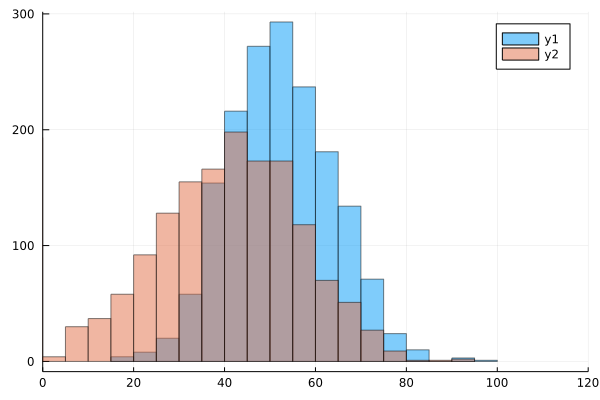

In [277]:
vzs_beforemagnets = Array{Float64}(undef, 0)
vzs_aftermagnets = Array{Float64}(undef, 0)
for i in 1:size(s.rs, 1)
    if s.rs[i][end][3] >= 0.0
        push!(vzs_beforemagnets, s.vzs[i][1])
        push!(vzs_aftermagnets, s.vzs[i][end])
    end
end
histogram(vzs_beforemagnets, alpha=0.5, bins=20, xlim=(0,120))
histogram!(vzs_aftermagnets, alpha=0.5, bins=20)

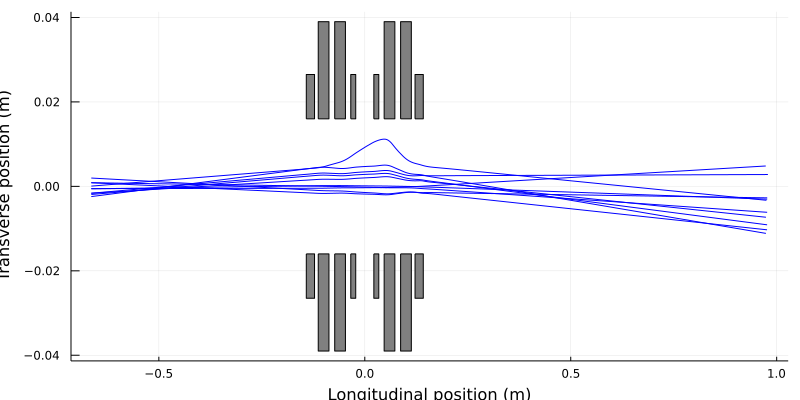

In [278]:
detecteds = s.rs[s.detectable];

plotmagnet()
# for i = 1:length(notdetecteds)
#     zpts = [r[3] for r in notdetecteds[i]]
#     xpts = [r[1] for r in notdetecteds[i]]
#     plot!(zpts,xpts,color="red",legend=false)
# end

for i = 1:length(detecteds)
    zpts = [r[3] for r in detecteds[i]]
    xpts = [r[1] for r in detecteds[i]]
    if 0 < s.vzs[s.detectable][i][end] < 15
        plot!(zpts,xpts,color="blue", legend=false)
#     else
#         plot!(zpts,xpts,color="red", legend=false)
    end
end

plot!(size=(800,400))
xlabel!("Longitudinal position (m)")
ylabel!("Transverse position (m)")

In [279]:
s.dts[s.detectable[1]] |> histogram

LoadError: ArgumentError: invalid index: false of type Bool